# Notebook 1: Data Acquisition and Exploratory Analysis (EDA)

**Project:** ML-Based Blockchain Trading Strategy
**Description:** This notebook handles the connection to the exchange, downloads historical OHLCV data, persists it to Google Drive, and performs an initial analysis of the market's structure.

## 1.1 Environment Setup
We mount Google Drive to ensure our data persists across sessions and install necessary libraries.

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Create Project Directory
import os
project_path = "/content/drive/MyDrive/Crypto_ML_Project"
if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"Created project folder at: {project_path}")

# 3. Install Necessary Libraries
!pip install ccxt pandas numpy matplotlib seaborn plotly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Configuration & Data Downloader

We use the Kraken exchange via the *CCXT* library. Kraken is used because Binance blocks Google Colab's US-based IP addresses. We target BTC/USD on a 1-Hour (1h) timeframe.

In [ ]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_kraken_data(symbol='BTC/USD', timeframe='1h', days_back=1000):
    """
    Fetches historical OHLCV data from Kraken and returns a cleaned DataFrame.
    """
    exchange = ccxt.kraken({'enableRateLimit': True})
    all_ohlcv = []

    # Calculate start timestamp in milliseconds
    since = exchange.milliseconds() - (days_back * 24 * 60 * 60 * 1000)

    print(f"Starting data download for {symbol}...")

    while True:
        try:
            # Kraken typically returns 720 candles per request
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
            if not ohlcv:
                break

            # Update 'since' for the next batch
            since = ohlcv[-1][0] + 1
            all_ohlcv.extend(ohlcv)

            print(f"Fetched {len(all_ohlcv)} total rows. Current date: {exchange.iso8601(ohlcv[-1][0])}")

            # Stop if the last candle is within the last hour
            if ohlcv[-1][0] >= exchange.milliseconds() - (60 * 60 * 1000):
                break

            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"Connection Error: {e}. Retrying...")
            time.sleep(5)
            continue

    # Convert to DataFrame
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# --- EXECUTION ---
# Downloading last 1000 days of data
df_raw = fetch_kraken_data(symbol='BTC/USD', timeframe='1h', days_back=1000)

# Save to Google Drive immediately
raw_data_path = f"{project_path}/BTC_1H_raw.csv"
df_raw.to_csv(raw_data_path, index=False)
print(f"\n SUCCESS: Data saved to {raw_data_path}")

Starting data download for BTC/USD...
Fetched 721 total rows. Current date: 2026-01-22T17:00:00.000Z

 SUCCESS: Data saved to /content/drive/MyDrive/Crypto_ML_Project/BTC_1H_raw.csv


## 1.3 Data Integrity & Quality Check

Before we analyze, we must ensure there are no missing rows or unexpected gaps in the hourly timeline.

In [ ]:
# 1. Check for Null Values
print("Missing Values Check:")
print(df_raw.isnull().sum())

# 2. Check for Time Gaps (Hourly Data)
# Calculate the difference between consecutive timestamps
time_diffs = df_raw['timestamp'].diff().dt.total_seconds() / 3600
gaps = time_diffs[time_diffs > 1]

print("-" * 30)
if len(gaps) > 0:
    print(f"Warning: Found {len(gaps)} gaps in the data.")
    print(gaps.head())
else:
    print("  No time gaps found. Data is continuous.")

# 3. Basic Statistics
df_raw.describe()

Missing Values Check:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64
------------------------------
No time gaps found. Data is continuous.


,timestamp,open,high,low,close,volume
count,721,721.000000,721.000000,721.000000,721.000000,721.000000
mean,2026-01-07 17:00:00,90841.057420,91047.574757,90629.936061,90842.500000,65.133331
min,2025-12-23 17:00:00,86715.800000,86832.200000,86271.400000,86715.800000,2.148018
25%,2025-12-31 05:00:00,88228.400000,88400.000000,87956.400000,88245.900000,17.855416
50%,2026-01-07 17:00:00,90518.600000,90630.700000,90400.000000,90520.400000,36.086483
75%,2026-01-15 05:00:00,92770.100000,93012.000000,92500.000000,92770.000000,77.575347
max,2026-01-22 17:00:00,97671.000000,97899.700000,97376.600000,97670.900000,729.165477
std,NaN,2821.160901,2838.828304,2806.823623,2819.750285,80.135044


## 1.4 Exploratory Data Analysis (Visualizations)

We now visualize the data to understand price trends, volume spikes, and volatility regimes.

### 1.4.1 Price & Volume Overview

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive chart with Price and Volume
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
               vertical_spacing=0.03, subplot_titles=('BTC Price', 'Volume'),
               row_width=[0.2, 0.7])

# Price Trace
fig.add_trace(go.Scatter(x=df_raw['timestamp'], y=df_raw['close'], name="Close Price"), row=1, col=1)

# Volume Trace
fig.add_trace(go.Bar(x=df_raw['timestamp'], y=df_raw['volume'], name="Volume"), row=2, col=1)

fig.update_layout(height=600, title_text="BTC/USD Hourly Market Overview", showlegend=False)
fig.show()

### 1.4.2 Analysis of Returns & Volatility

ML models perform better on Returns than absolute prices. We examine the distribution of these returns.

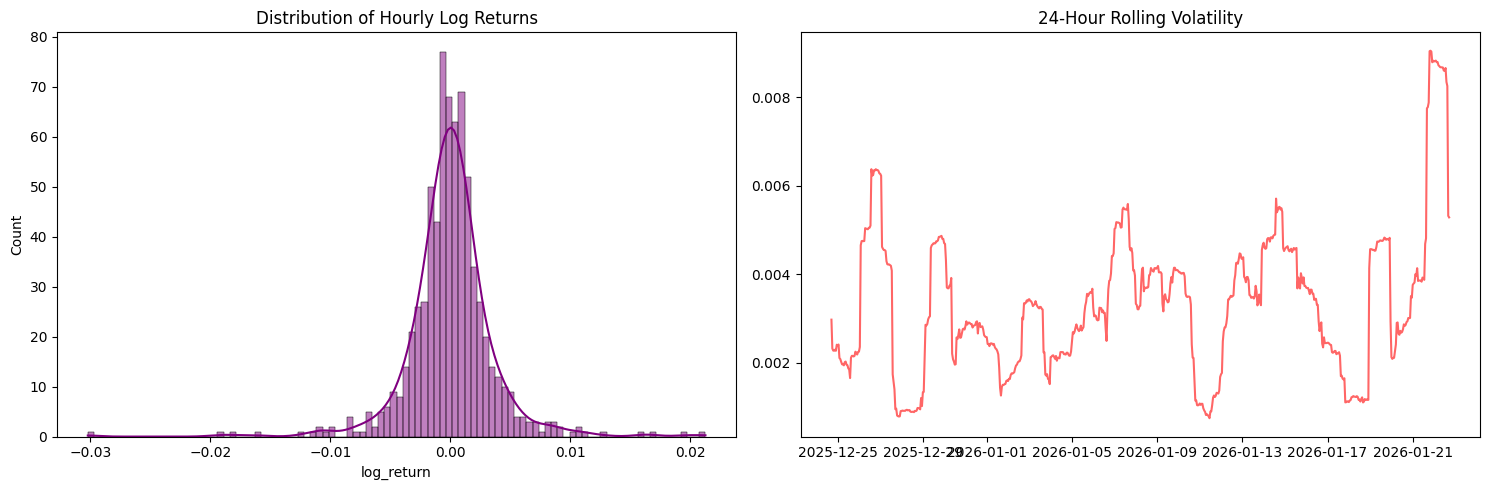

In [ ]:
# Calculate Log Returns
df_raw['log_return'] = np.log(df_raw['close'] / df_raw['close'].shift(1))

plt.figure(figsize=(15, 5))

# Plot 1: Distribution of Returns
plt.subplot(1, 2, 1)
sns.histplot(df_raw['log_return'].dropna(), bins=100, kde=True, color='purple')
plt.title('Distribution of Hourly Log Returns')

# Plot 2: Volatility Over Time (24h Rolling Std)
plt.subplot(1, 2, 2)
rolling_vol = df_raw['log_return'].rolling(window=24).std()
plt.plot(df_raw['timestamp'], rolling_vol, color='red', alpha=0.6)
plt.title('24-Hour Rolling Volatility')

plt.tight_layout()
plt.show()

## 1.5 Data Discussion & Next Steps

**Observations:**
- **1. Stationarity:** The Price chart shows a clear "trend," meaning the mean changes over time (Non-Stationary). Our ML models will struggle with this. We must use the Log Returns (visualized above) which are centered around zero.
- **2. Volatility Clustering:** High spikes in volatility tend to cluster together. This suggests that the market has "regimes" (Quiet vs. Chaotic).
- **3. Fat Tails:** The histogram shows that extreme moves (3%+) happen more often than a normal distribution would predict. This is a classic "Black Swan" characteristic of crypto.
